In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%ls

drive/  sample_data/


In [3]:
%cd /content/drive/Shareddrives/ECS174/ECS174Project

/content/drive/.shortcut-targets-by-id/1zcb8WXmpzPR8LBuK3Sg-LhTD6MtlZHvp/ECS174Project


In [4]:
%ls

'Car Counting.v1i.darknet (1)'/   images/              vehicle_color_haze_free_model.h5      yolo/
'Car Counting.v1i.darknet.zip'    latest.ipynb        'Vehicle Detection.v2-vvvv.darknet'/
 ECS174GroupProject.ipynb         test_example/        with_bus_and_truck.ipynb
 ECS174report/                    test_example.ipynb   with_CV.ipynb


In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

names_path = "./yolo/coco.names"

def calculate_overall_accuracy(tp, fp, fn):
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    return accuracy

def calculate_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

def predict_cars_buses_trucks(net, yolo_version, show_details):
    layer_names = net.getLayerNames()

    # Handle different formats of getUnconnectedOutLayers output
    unconnected_out_layers = net.getUnconnectedOutLayers()
    if isinstance(unconnected_out_layers[0], list) or isinstance(unconnected_out_layers[0], np.ndarray):
        output_layers = [layer_names[i[0] - 1] for i in unconnected_out_layers]
    else:
        output_layers = [layer_names[i - 1] for i in unconnected_out_layers]

    # Load COCO names
    with open(names_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]

    # Function to get image paths from a folder
    def get_image_paths(folder):
        image_paths = []
        for root, dirs, files in os.walk(folder):
            for file in files:
                if file.endswith(".jpg"):
                    image_paths.append(os.path.join(root, file))
                    break
        return image_paths

    test_folder = "./test_example"

    # Get all image paths from the test folder
    image_paths = get_image_paths(test_folder)

    # Overall metrics
    overall_tp_cars, overall_tp_buses, overall_tp_trucks = 0, 0, 0
    overall_fp_cars, overall_fp_buses, overall_fp_trucks = 0, 0, 0
    overall_fn_cars, overall_fn_buses, overall_fn_trucks = 0, 0, 0

    # Process each image
    for image_path in image_paths:
        ground_truth = {"num_cars": 0, "num_buses": 0, "num_trucks": 0}

        # Get ground truth from the image path
        with open(image_path.replace(".jpg", ".txt"), "r") as f:
            labels = [line.split() for line in f.readlines()]
            for label in labels:
                match label[0]:
                    # Ignore motorcycles
                    case "0": continue
                    case "1": ground_truth["num_cars"] += 1
                    case "2": ground_truth["num_cars"] += 1
                    case "3": ground_truth["num_trucks"] += 1
                    case "4": ground_truth["num_cars"] += 1
                    case "5": ground_truth["num_buses"] += 1
                    case "6": ground_truth["num_cars"] += 1
                    case "7": ground_truth["num_cars"] += 1

        image = cv2.imread(image_path)

        # Check if image is loaded
        if image is None:
            print(f"Error: Unable to load image at {image_path}")
            continue

        height, width, channels = image.shape

        # Detecting objects
        blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        net.setInput(blob)
        outs = net.forward(output_layers)

        # Initialize parameters
        class_ids = []
        confidences = []
        boxes = []

        # Extract information from the detections
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    # Object detected
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        # Non-max suppression
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        # Count cars, buses, and trucks
        car_count = 0
        bus_count = 0
        truck_count = 0
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                if label == "car":
                    car_count += 1
                    if show_details:
                        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                elif label == "bus":
                    bus_count += 1
                    if show_details:
                        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
                        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                elif label == "truck":
                    truck_count += 1
                    if show_details:
                        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        if show_details:
            print(f"Ground truth:\t{ground_truth['num_cars']} cars,\t{ground_truth['num_buses']} buses,\t{ground_truth['num_trucks']} trucks")
            print(f"Predicted: \t{car_count} cars,\t{bus_count} buses,\t{truck_count} trucks")

            # Convert the image from BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 10))
            plt.imshow(image_rgb)
            plt.axis('off')
            plt.title(f"YOLOv{yolo_version} Detections", fontsize=20)
            plt.show()

        # Calculate performance metrics
        tp_cars, tp_buses, tp_trucks = 0, 0, 0
        fp_cars, fp_buses, fp_trucks = 0, 0, 0
        fn_cars, fn_buses, fn_trucks = 0, 0, 0

        for label in labels:
            class_id = int(label[0])
            x = float(label[1]) * width
            y = float(label[2]) * height
            w = float(label[3]) * width
            h = float(label[4]) * height

            # Cars
            if class_id in [1, 2, 4, 6, 7]:
                if car_count > 0:
                    tp_cars += 1
                    car_count -= 1
                else:
                    fn_cars += 1
            # Bus
            elif class_id == 5:
                if bus_count > 0:
                    tp_buses += 1
                    bus_count -= 1
                else:
                    fn_buses += 1
            # Truck
            elif class_id == 3:
                if truck_count > 0:
                    tp_trucks += 1
                    truck_count -= 1
                else:
                    fn_trucks += 1

        fp_cars = car_count
        fp_buses = bus_count
        fp_trucks = truck_count

        # Update overall metrics
        overall_tp_cars += tp_cars
        overall_tp_buses += tp_buses
        overall_tp_trucks += tp_trucks

        overall_fp_cars += fp_cars
        overall_fp_buses += fp_buses
        overall_fp_trucks += fp_trucks

        overall_fn_cars += fn_cars
        overall_fn_buses += fn_buses
        overall_fn_trucks += fn_trucks

        if show_details:
            print(f"True Positives - Cars: {tp_cars}, Buses: {tp_buses}, Trucks: {tp_trucks}")
            print(f"False Positives - Cars: {fp_cars}, Buses: {fp_buses}, Trucks: {fp_trucks}")
            print(f"False Negatives - Cars: {fn_cars}, Buses: {fn_buses}, Trucks: {fn_trucks}")

    # Calculate the overall accuracy
    overall_tp = overall_tp_cars + overall_tp_buses + overall_tp_trucks
    overall_fp = overall_fp_cars + overall_fp_buses + overall_fp_trucks
    overall_fn = overall_fn_cars + overall_fn_buses + overall_fn_trucks
    overall_accuracy = calculate_overall_accuracy(overall_tp, overall_fp, overall_fn)

    # Calculate overall metrics
    car_metrics = calculate_metrics(overall_tp_cars, overall_fp_cars, overall_fn_cars)
    bus_metrics = calculate_metrics(overall_tp_buses, overall_fp_buses, overall_fn_buses)
    truck_metrics = calculate_metrics(overall_tp_trucks, overall_fp_trucks, overall_fn_trucks)

    print(f"Overall Performance of YOLOv{yolo_version} on the test set:")
    print(f"Precision for Cars: {car_metrics[0]:.2f}, Recall for Cars: {car_metrics[1]:.2f}, F1 Score for Cars: {car_metrics[2]:.2f}")
    print(f"Precision for Buses: {bus_metrics[0]:.2f}, Recall for Buses: {bus_metrics[1]:.2f}, F1 Score for Buses: {bus_metrics[2]:.2f}")
    print(f"Precision for Trucks: {truck_metrics[0]:.2f}, Recall for Trucks: {truck_metrics[1]:.2f}, F1 Score for Trucks: {truck_metrics[2]:.2f}")

    print(f"Overall Accuracy: {overall_accuracy:.2f}")

Ground truth:	6 cars,	0 buses,	2 trucks
Predicted: 	1 cars,	0 buses,	0 trucks


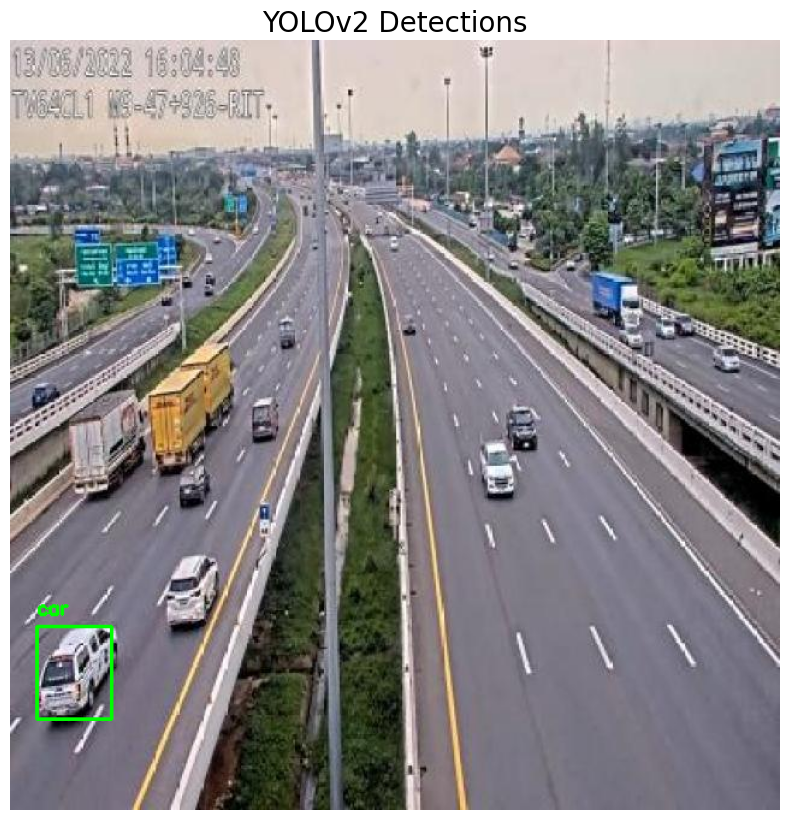

True Positives - Cars: 1, Buses: 0, Trucks: 0
False Positives - Cars: 0, Buses: 0, Trucks: 0
False Negatives - Cars: 5, Buses: 0, Trucks: 2
Overall Performance of YOLOv2 on the test set:
Precision for Cars: 1.00, Recall for Cars: 0.17, F1 Score for Cars: 0.29
Precision for Buses: 0.00, Recall for Buses: 0.00, F1 Score for Buses: 0.00
Precision for Trucks: 0.00, Recall for Trucks: 0.00, F1 Score for Trucks: 0.00
Overall Accuracy: 0.12


In [6]:
show_details = True

# Load YOLOv2
weights_path = "./yolo/yolov2.weights"
config_path = "./yolo/yolov2.cfg"

net = cv2.dnn.readNet(weights_path, config_path)

predict_cars_buses_trucks(net, yolo_version=2, show_details=show_details)

Ground truth:	6 cars,	0 buses,	2 trucks
Predicted: 	12 cars,	0 buses,	3 trucks


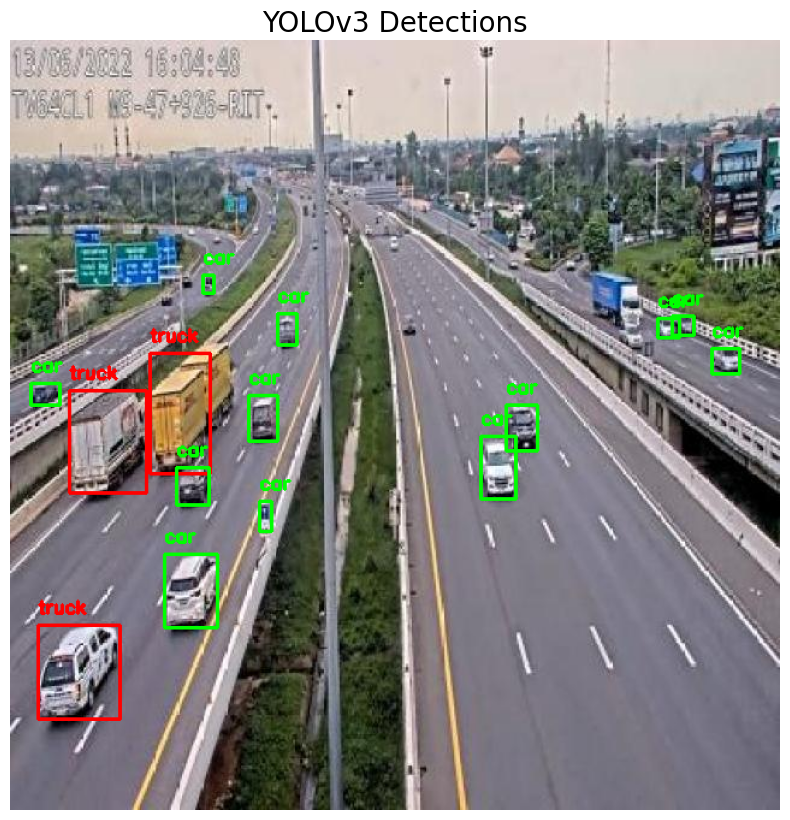

True Positives - Cars: 6, Buses: 0, Trucks: 2
False Positives - Cars: 6, Buses: 0, Trucks: 1
False Negatives - Cars: 0, Buses: 0, Trucks: 0
Overall Performance of YOLOv3 on the test set:
Precision for Cars: 0.50, Recall for Cars: 1.00, F1 Score for Cars: 0.67
Precision for Buses: 0.00, Recall for Buses: 0.00, F1 Score for Buses: 0.00
Precision for Trucks: 0.67, Recall for Trucks: 1.00, F1 Score for Trucks: 0.80
Overall Accuracy: 0.53


In [7]:
# Load YOLOv3
weights_path = "./yolo/yolov3.weights"
config_path = "./yolo/yolov3.cfg"

net = cv2.dnn.readNet(weights_path, config_path)

predict_cars_buses_trucks(net, yolo_version=3, show_details=show_details)

Ground truth:	6 cars,	0 buses,	2 trucks
Predicted: 	10 cars,	0 buses,	3 trucks


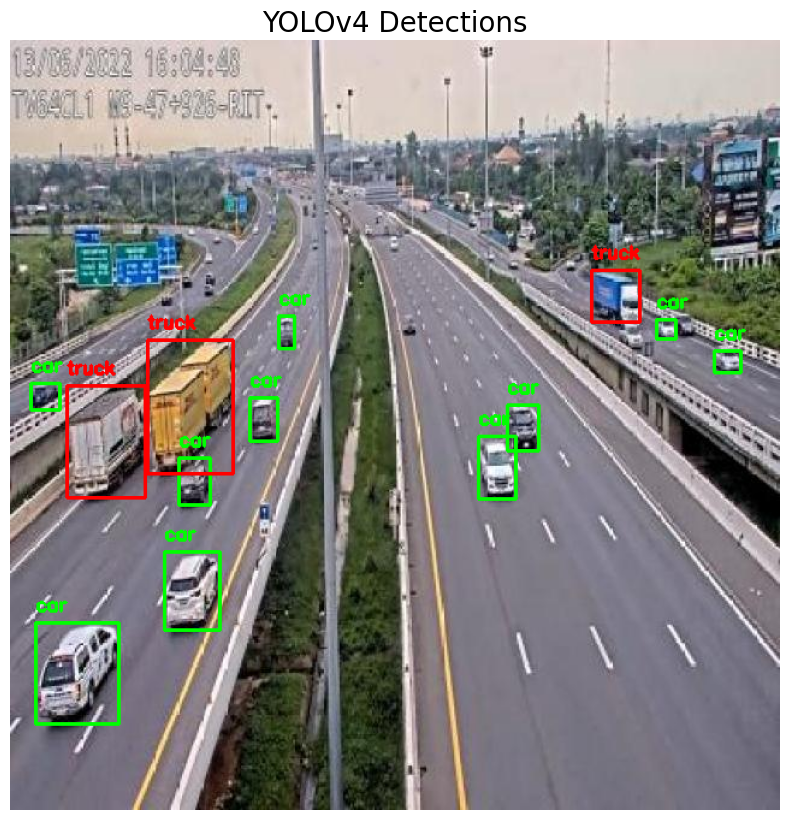

True Positives - Cars: 6, Buses: 0, Trucks: 2
False Positives - Cars: 4, Buses: 0, Trucks: 1
False Negatives - Cars: 0, Buses: 0, Trucks: 0
Overall Performance of YOLOv4 on the test set:
Precision for Cars: 0.60, Recall for Cars: 1.00, F1 Score for Cars: 0.75
Precision for Buses: 0.00, Recall for Buses: 0.00, F1 Score for Buses: 0.00
Precision for Trucks: 0.67, Recall for Trucks: 1.00, F1 Score for Trucks: 0.80
Overall Accuracy: 0.62


In [8]:
# Load YOLOv4
weights_path = "./yolo/yolov4.weights"
config_path = "./yolo/yolov4.cfg"

net = cv2.dnn.readNet(weights_path, config_path)

predict_cars_buses_trucks(net, yolo_version=4, show_details=show_details)